In [ ]:
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from keras.layers import GRU
from keras.layers import Conv1D, MaxPooling1D, Flatten
from numpy.random import default_rng

In [ ]:
import logging


# Configure logging to redirect logs to a file
logging.basicConfig(filename='clientdata.txt', level=logging.INFO)


class BaseClient:
    """Serves as the base client for OOP inheritance"""
    def __init__(self, client_id, max_rounds, local_model, local_df):
        self.client_id = client_id
        self.max_rounds = max_rounds
        self.current_round = 0
        self.local_model = local_model
        self.local_df = local_df
        self.split_local_dfs = self._split_df(self.local_df, self.max_rounds)

    @staticmethod
    def _split_df(df, num_splits):
        """Splits dataframes into instances for rounds of training"""
        split_dfs = []
        split_size = len(df) // num_splits
        for i in range(num_splits):
            if i == num_splits - 1:
                split_dfs.append(df.iloc[i * split_size:])
            else:
                split_dfs.append(df.iloc[i * split_size: (i + 1) * split_size])
        return split_dfs


class DeepLearningClient(BaseClient):
    def __init__(self, client_id, max_rounds, local_model, local_df, target_col, epochs=1, batch_size=32):
        super().__init__(client_id, max_rounds, local_model, local_df)
        self.epochs = epochs
        self.batch_size = batch_size
        self.target_col = target_col

    def get_client_models_weights(self):
        """Gets weights of current instance of local model"""
        return self.local_model.get_weights()

    def train_local(self):
        """Trains locally based on the current round of training"""
        if self.current_round < len(self.split_local_dfs):
            current_df = self.split_local_dfs[self.current_round]
            logging.info(f"Training client {self.client_id} round number: {self.current_round}\n{current_df}")
            x = current_df.drop(columns=[self.target_col])
            y = current_df[self.target_col]
            # Reshape the features to fit the model input
            x = x.values.reshape(-1, 1, x.shape[1])
            self.local_model.fit(x, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        else:
            logging.info(f"No data for client {self.client_id} at round {self.current_round}")


In [ ]:
class BaseServer:
   def __init__(self, max_clients, max_rounds, raw_csv):
    self.max_clients = max_clients
    self.max_rounds = max_rounds
    self.raw_csv = pd.read_csv(raw_csv)
    self.clients_df = None
    self.eval_df = None
    self.global_model = None
    self.client_struct = []
    self.current_global_round = 0

   def init_dataframes(self):
    numerical_features = ['t', 'cat_id', 'pe_id', 'load']
    scaler = MinMaxScaler()
    self.raw_csv[numerical_features] = scaler.fit_transform(self.raw_csv[numerical_features])
    self.clients_df, self.eval_df = train_test_split(self.raw_csv, test_size=0.2)
    self.clients_df = self.clients_df.sort_values(by='t')
    #logging.info(f"The raw csv:{self.raw_csv}\nThe clients dataframe: {self.clients_df}\nThe evaluation dataframe: {self.eval_df}")


   def init_client_struct(self):
    for client_id in range(self.max_clients):
      current_client_df = self.clients_df[self.clients_df['cell_id'] == client_id]
      #logging.info(f"client number: {client_id}, has the following slice:\n{current_client_df}")
      self.client_struct.append(DeepLearningClient(client_id, self.max_rounds, self.global_model, current_client_df, 'load'))

   def init_global_model(self):
       raise NotImplementedError

   def get_input_shape(self):
    num_timesteps = 1
    num_features = self.raw_csv.shape[1] - 1
    return (num_timesteps, num_features)

   def train_clinets(self):
    for client in self.client_struct:
      client.train_local()
      #logging.info(f"Trained, {client}")

   def update_clients(self):
    for client in self.client_struct:
      client.current_round = self.current_global_round
      client.local_model.set_weights(self.global_model.get_weights())

   def fed_avg(self):
    clients_num = len(self.client_struct)
    if self.current_global_round == 0:
        # initialize weights to zeros if it's the first round
        global_weights = [np.zeros_like(w) for w in self.global_model.get_weights()]
    else:
        # otherwise, start with the current weights
        global_weights = [w for w in self.global_model.get_weights()]

    for client in self.client_struct:
        local_weights = client.get_client_models_weights()
        for i, weight in enumerate(local_weights):
            global_weights[i] += weight / clients_num

    self.global_model.set_weights(global_weights)
    #logging.info(f"Federated averaging completed on global round {self.current_global_round} \nthe global weights were:{global_weights}")

    self.current_global_round += 1


   def evaluate_model(self):
      x_eval = self.eval_df.drop(columns=['load'])
      y_eval = self.eval_df['load']
      x_eval = x_eval.values.reshape(-1, 1, x_eval.shape[1])
      y_pred = self.global_model.predict(x_eval)

      # Calculate MSE
      mse = mean_squared_error(y_eval, y_pred)
      print("Mean Squared Error:", mse)

      # Calculate RMSE
      rmse = np.sqrt(mse)
      print("Root Mean Squared Error:", rmse)
      # Calculate MAE
      mae = mean_absolute_error(y_eval, y_pred)
      print("Mean Absolute Error:", mae)

      return {'Mean Squared Error': mse, 'Root Mean Squared Error': rmse, 'Mean Absolute Error': mae}


   def init_server(self):
    self.init_dataframes()
    self.init_global_model()
    self.init_client_struct()

   def main(self):
    self.init_server()
    while self.current_global_round < self.max_rounds:
      self.train_clinets()
      self.fed_avg()
      self.update_clients()
    self.evaluate_model()

class LSTMServer(BaseServer):
  def init_global_model(self):
      model = Sequential()
      model.add(LSTM(64, input_shape=self.get_input_shape(), return_sequences=True))
      model.add(Dropout(0.2))
      model.add(LSTM(32, return_sequences=False))
      model.add(Dropout(0.2))
      model.add(Dense(1, activation='linear'))
      model.compile(loss='mean_squared_error', optimizer='adam')
      self.global_model = model

class GRUServer(BaseServer):
  def init_global_model(self):
        model = Sequential()
        model.add(GRU(64, input_shape=self.get_input_shape(), return_sequences=True))
        model.add(Dropout(0.2))
        model.add(GRU(32, return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation='linear'))
        model.compile(loss='mean_squared_error', optimizer='adam')
        self.global_model = model

class NNServer(BaseServer):
    def init_global_model(self):
        model = Sequential()
        model.add(Dense(64, input_dim=self.get_input_shape()[1], activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation='linear'))
        model.compile(loss='mean_squared_error', optimizer='adam')
        self.global_model = model

    def evaluate_model(self):
      x_eval = self.eval_df.drop(columns=['load'])
      y_eval = self.eval_df['load']
      y_pred = self.global_model.predict(x_eval)

      # Calculate MSE
      mse = mean_squared_error(y_eval, y_pred)
      print("Mean Squared Error:", mse)

      # Calculate RMSE
      rmse = np.sqrt(mse)
      print("Root Mean Squared Error:", rmse)
      # Calculate MAE
      mae = mean_absolute_error(y_eval, y_pred)
      print("Mean Absolute Error:", mae)

      return {'Mean Squared Error': mse, 'Root Mean Squared Error': rmse, 'Mean Absolute Error': mae}


class CNNServer(BaseServer):
    def init_global_model(self):
        # Initialize a 1D CNN
        model = Sequential()
        model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=self.get_input_shape()))
        model.add(MaxPooling1D(pool_size=1))
        model.add(Flatten())
        model.add(Dense(50, activation='relu'))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        self.global_model = model

class BaseServerDP(BaseServer):
  '''
  The Gaussian mechanism adds a certain amount of random noise to the query result, which will ensure
  that individual's data are kept private. It's defined as M(x) = x + N(0, sigma^2) where x is the input,
  and N(0, sigma^2) is Gaussian noise with mean 0 and variance sigma^2. The noise scale sigma is
  calculated using the privacy budget epsilon, the dataset size n, and the sensitivity Delta,
  which in this context is the maximum change in the model's weights that could be caused by
  the removal or addition of one example.
  '''
  def __init__(self, max_clients, max_rounds, raw_csv, epsilon):
    super().__init__(max_clients, max_rounds, raw_csv)
    self.epsilon = epsilon

  def fed_avg(self):
      clients_num = len(self.client_struct)
      if self.current_global_round == 0:
        # initialize weights to zeros if it's the first round
        global_weights = [np.zeros_like(w) for w in self.global_model.get_weights()]
      else:
        # otherwise, start with the current weights
        global_weights = [w for w in self.global_model.get_weights()]

      for client in self.client_struct:
          local_weights = client.get_client_models_weights()
          for i, weight in enumerate(local_weights):
              global_weights[i] += weight / clients_num

      # Adding differential privacy by adding gaussian noise
      rng = default_rng()
      n = len(self.raw_csv)
      Delta = 1 # Sensitivity can be set to 1 in the context of federated learning
      sigma = np.sqrt(2 * np.log(1.25 / self.epsilon)) * Delta / n
      for i in range(len(global_weights)):
          noise = rng.normal(loc=0, scale=sigma, size=global_weights[i].shape)
          global_weights[i] += noise

      self.global_model.set_weights(global_weights)
      #print("Federated averaging with differential privacy completed")

      self.current_global_round += 1

class LSTMServerDP(BaseServerDP, LSTMServer):
  pass

class GRUServerDP(BaseServerDP, GRUServer):
  pass

class NNServerDP(BaseServerDP, NNServer):
  pass

class CNNServerDP(BaseServerDP, CNNServer):
  pass


In [ ]:
ServerLSTM = LSTMServer(5, 5, "nwdaf_data.csv")
ServerGRU = GRUServer(5, 5, "nwdaf_data.csv")
ServerNN = NNServer(5, 5, "nwdaf_data.csv")
ServerCNN = CNNServer(5, 5, "nwdaf_data.csv")

ServerLSTMDP = LSTMServerDP(5, 5, "nwdaf_data.csv", 0.5)
ServerGRUDP = GRUServerDP(5, 5, "nwdaf_data.csv", 0.5)
ServerNNDP = NNServerDP(5, 5, "nwdaf_data.csv", 0.5)
ServerCNNDP = CNNServerDP(5, 5, "nwdaf_data.csv", 0.5)
print("LSTM")
ServerLSTM.main()
print("LSTM DP")
ServerLSTMDP.main()
print("GRU")
ServerGRU.main()
print("GRU DP")
ServerGRUDP.main()
print("NN")
ServerNN.main()
print("NN DP")
ServerNNDP.main()
print("CNN")
ServerCNN.main()
print('CNN DP')
ServerCNNDP.main()




LSTM
Mean Squared Error: 0.06833111798767642
Root Mean Squared Error: 0.26140221496321797
Mean Absolute Error: 0.15515499313049597
LSTM DP
Mean Squared Error: 0.07273404440520158
Root Mean Squared Error: 0.2696924997199618
Mean Absolute Error: 0.1527126128388567
GRU
Mean Squared Error: 0.12130867212109518
Root Mean Squared Error: 0.34829394499631366
Mean Absolute Error: 0.22224425012326118
GRU DP
Mean Squared Error: 0.1014437845882537
Root Mean Squared Error: 0.3185024090776296
Mean Absolute Error: 0.20691409896793087
NN


Mean Squared Error: 0.3256389417167346
Root Mean Squared Error: 0.570647826348909
Mean Absolute Error: 0.3656263172791186
NN DP


Mean Squared Error: 0.4925347471538593
Root Mean Squared Error: 0.7018081982663492
Mean Absolute Error: 0.4649225506516924
CNN
Mean Squared Error: 5785.174340957582
Root Mean Squared Error: 76.0603335580221
Mean Absolute Error: 56.78127149621326
CNN DP
Mean Squared Error: 2723.287738185957
Root Mean Squared Error: 52.18512947369161
Mean Absolute Error: 38.10310181717348


   t  cell_id  cat_id  pe_id       load  has_anomaly
0  0        0       0      0   4.997074            0
1  0        0       0      1  16.004322            0
2  0        0       0      2  52.985386            0
3  0        0       0      3   0.999767            0
4  0        0       0      4   5.000597            0
Unique values in 'load' column:  [ 4.99707406 16.0043221  52.98538596 ... 90.08669958  1.00640726
  6.02018468]


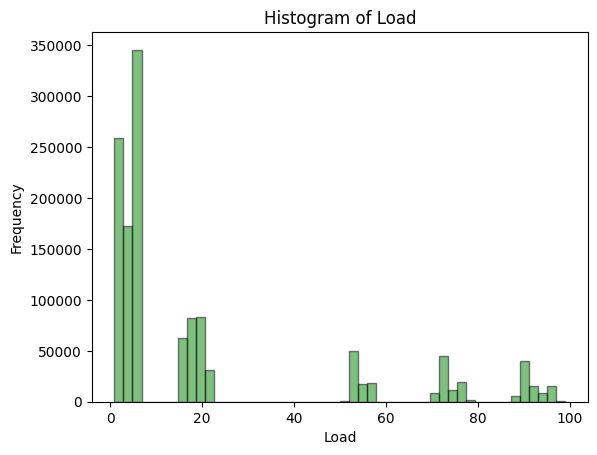

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from a CSV file
df = pd.read_csv('nwdaf_data.csv')

# Perform basic analysis
print(df.head())

# Print the unique values in the 'load' column
print("Unique values in 'load' column: ", df['load'].unique())

# Plot a histogram of the 'load' data
plt.hist(df['load'], bins=50, alpha=0.5, color='g', edgecolor='black')
plt.title('Histogram of Load')
plt.xlabel('Load')
plt.ylabel('Frequency')
plt.show()


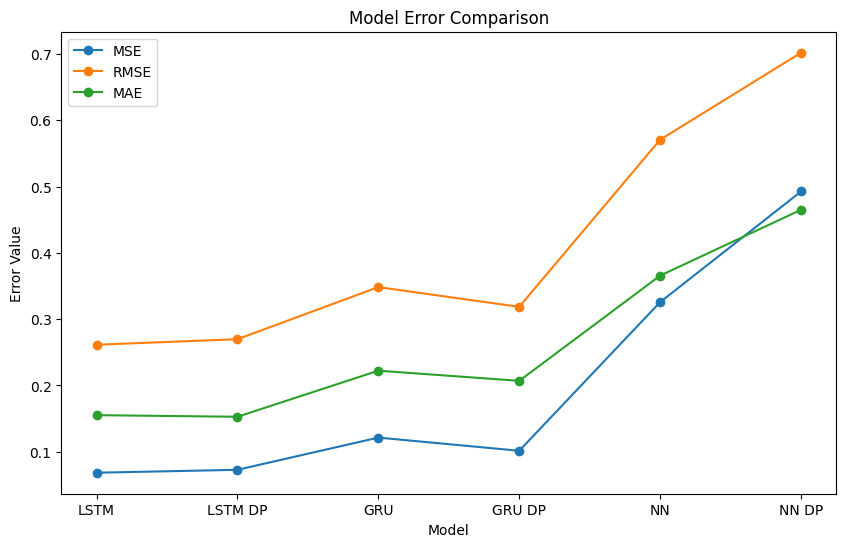

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Define data
data = {
    'Model': ['LSTM', 'LSTM DP', 'GRU', 'GRU DP', 'NN', 'NN DP'],
    'MSE': [0.06833111798767642, 0.07273404440520158, 0.12130867212109518, 0.1014437845882537, 0.3256389417167346, 0.4925347471538593],
    'RMSE': [0.26140221496321797, 0.2696924997199618, 0.34829394499631366, 0.3185024090776296, 0.570647826348909, 0.7018081982663492],
    'MAE': [0.15515499313049597, 0.1527126128388567, 0.22224425012326118, 0.20691409896793087, 0.3656263172791186, 0.4649225506516924]
}

# Convert to pandas DataFrame
df = pd.DataFrame(data)

# Set the figure size
plt.figure(figsize=(10, 6))

# Create scatter plot for each error type
for error_type in ['MSE', 'RMSE', 'MAE']:
    plt.plot('Model', error_type, data=df, marker='o', label=error_type)

# Set title and labels
plt.title('Model Error Comparison')
plt.xlabel('Model')
plt.ylabel('Error Value')

# Add a legend
plt.legend()

# Show the plot
plt.show()
